##Reproducing the kibet and Machanick (2015) paper using PBM data

This Ipython notebook aims to reproduce the analsysis performed in the above paper using PBM data. This is in response to a reviwers comment that an analsysis using PBM data would affect the conclusion of the paper. 


In this notebok, we highlight the differences observed in the two analsysis.

##Methodology

When usng PBM data to rank motifs, we mainly adopted the defenition of positive and negative sets described by Chen et al 2007. A given motif is used to score a 36bp sequence for each spot using the different scoring function described in the main paper.

###Data
For this anlaysis, we only found 8 transcription factors which had comparable data in ChIP-seq and PBM. These were: egr1, esrra, gata3, hnf4a, mafk, max, myb, pou2f2 and tcf3.

The PBM data was downloaded from UNIPROBE database. The specific data used in this analysis were published by Badis, Berger, Philippakis, Talukder, Gehrke, Jaeger, Chan, et al., Science 2009

###First we load all the required libraries

In [1]:
import pandas as pd
import os
import errno


import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline 

#Get the figures displayed inline

Import the functions o run the analysis with

In [2]:
import assess_pbm as assess

In [3]:
import errno
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [3]:
import os
BASE_DIR = os.path.dirname(os.path.dirname(os.path.abspath('assess_pbm.py')))

In [5]:
#tf_list = "egr1 esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
tf_list = ['egr1']
for tf in tf_list:
    import glob
    pbm_list = glob.glob('%s/PBM/Data/%s/*' % (BASE_DIR, tf.capitalize()))
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    mkdir_p(results_path)
    for key in assess.score_extensions:
        assess.run_all_pbm(tf, key, '%s/Motifs/%s.meme' 
                       %(BASE_DIR, tf), pbm_list, results_path)

In [74]:
tf_list = "egr1 esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()

score_key = ['energy', 'gomer', 'sumlog', 'sumoc','maxoc', 'ama', 'maxlog']
stat = 'mncp'
for tf in tf_list:
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    raw_data = []
    raw_data.append(["Motif"])
    flag = 0
    for key in score_key:
        i = 1
        raw_data[0].append(key)
        with open('%s/%s.%s' % (results_path,tf,key)) as score_out:
            for line in score_out:
                if line.split()[1]=="AUC":
                    continue
                else:
                    if flag ==0:
                        raw_data.append([line.split()[0]])
                        raw_data[i].append(line.split()[2])
                        i+=1
                    else:
                        raw_data[i].append(line.split()[2])
                        i+=1
            flag = 1
        with open("%s/%s_%s.rawscores" %(results_path,tf, stat), 'w') as raw_out:
            for row in raw_data:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')

In [6]:
#!/usr/bin/python
from __future__ import print_function
import sys
from math import log
import os

def mot_summary(motif_file, raw_scores, out_file):
    '''
    Summary of motif and score
    '''
    found = 0
    row = 0
    n_rows = 0
    entropy = 0
    total_entropy = 0
    motifs = 0
    name = ""
    raw_dict = {}
    with open(out_file, "w") as write_out:

        with open(raw_scores) as raw_in:
            for line in raw_in:
                raw_dict[line.split()[0]] = line.split()[1:]
        out = "Motif_name\tMotif_IC\tAverage_IC\tMotif_length\t%s\t%s\t%s\t%s\n" % \
              (raw_dict["Motif"][0], raw_dict["Motif"][1], raw_dict["Motif"][2], raw_dict["Motif"][3])

        write_out.write(out)
        with open(motif_file, "r") as motif_file:
            for line in motif_file:
                words = line.split()
                if found == 0:
                    if line.startswith("MOTIF"):
                        # allow for motifs without an alternative name
                        if len(words) < 3:
                            words.append("")
                        name = (words[1])
                        found = 1
                        motifs += motifs
                        entropy = 0
                        continue
                if found == 1:
                    if line.startswith("letter-probability"):
                        n_rows = int((line.split("w="))[1].split()[0])
                        found = 2
                    continue
                if found == 2:
                    if line == "\n":
                        continue
                    else:
                        check = 0
                    for val in words:
                        if float(val) > 0:
                            check += float(val) * log(float(val))/log(2.0)
                            entropy += float(val) * log(float(val))/log(2.0)
                    row += 1
                    if row >= n_rows:
                        v = 2*n_rows+entropy
                        out = '%s\t%f\t%f\t%i\t%f\t%f\t%f\t%f\n'\
                              % (name, v, (v/n_rows), n_rows, float(raw_dict[name][0]), float(raw_dict[name][1]),
                                 float(raw_dict[name][2]), float(raw_dict[name][3]))
                        write_out.write(out)
                        #n+= 1
                        #print(n)
                        found = 0
                        row = 0
                        total_entropy += (v/n_rows)

In [76]:
statistics = ['auc','mncp']
tf_list = "egr1 esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
for stat in statistics:
    for tf in tf_list:
        meme_file = '%s/Motifs/%s.meme' %(BASE_DIR, tf)
        results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
        test = mot_summary(meme_file,"%s/%s_%s.rawscores" % (results_path, tf, stat),
                           "%s/%s_%s_score_ic.txt" % (results_path, tf, stat))

###Figure 3 cannot be replicated for PBM data since it deal with the effects of sequence length on motif ranking

###Figure 4 cannot be replicated for PBM data since it deal with cell line specifc motif binding

###Figure 5...Effect of statistics on motif ranking

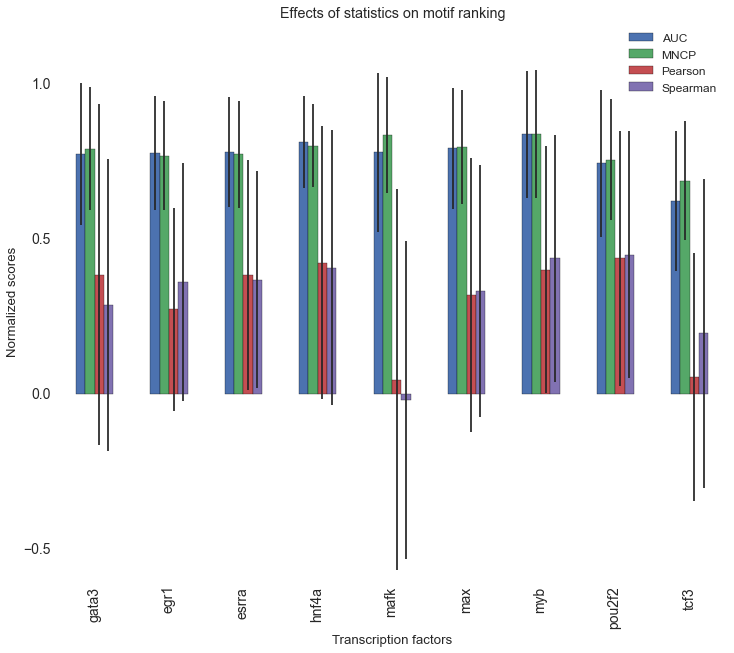

In [73]:
score = 'energy'
tf_list = "egr1 esrra hnf4a mafk max myb pou2f2 tcf3 ".split()
tf = 'gata3'
results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
chip = pd.read_table('%s/%s.%s' % (results_path, tf, score), index_col='Motif')
chip = chip/chip.max()
chip_std = chip.std().to_frame(name=tf).T
chip_mean = np.mean(chip).to_frame(name=tf)
chip_mean_test = chip_mean.T

for tf in tf_list:
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    chip = pd.read_table('%s/%s.%s' % (results_path, tf, score), index_col='Motif')
    chip = chip/chip.max()
    chip_s = chip.std().to_frame(name=tf)
    chip_std = chip_std.append(chip_s.T)
    chip_mean = np.mean(chip).to_frame(name=tf)
    
    chip_mean_test = chip_mean_test.append(chip_mean.T)
ax = chip_mean_test.plot(kind='bar',yerr=chip_std, figsize=(12,10),
                         title="Effects of statistics on motif ranking", fontsize=14)
#ax.grid(False)
ax.set_xlabel("Transcription factors")
ax.set_ylabel("Normalized scores")
ax.set_axis_bgcolor('W')
fig = ax.get_figure()

#fig.savefig('../Figures/Figure5_score_and_statistic_new.pdf')

##Figure 6...Effect of scoring sequences on ranks based on AUC statistic: Figure S1

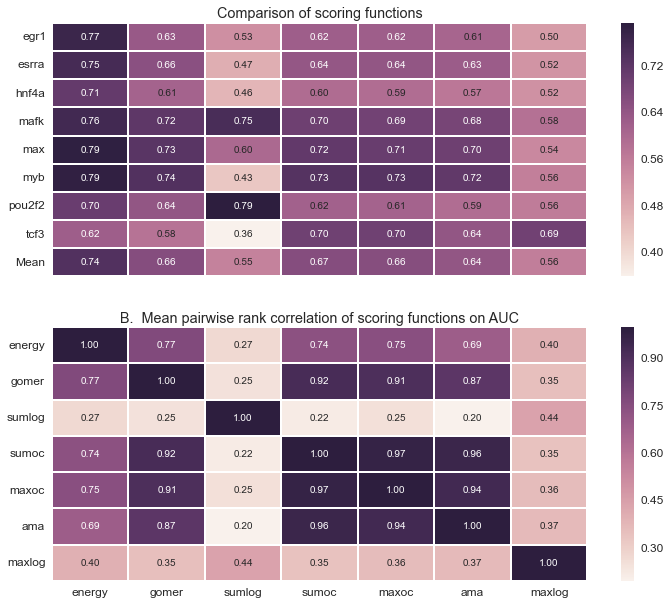

In [11]:
tf_list = "egr1 esrra hnf4a mafk max myb pou2f2 tcf3 ".split()
stat='auc'


fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    mot_score =pd.read_table("%s/%s_%s.rawscores" % (results_path, tf, stat), index_col="Motif")
    #mot_score =pd.read_table("../Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("Comparison of scoring functions")

tf = 'esrra'
#stat = 'mncp'
results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
mot_score =pd.read_table("%s/%s_%s.rawscores" % (results_path, tf, stat), index_col="Motif")
#mot_score =pd.read_table("../Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))
tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    mot_score =pd.read_table("%s/%s_%s.rawscores" % (results_path, tf, stat), index_col="Motif")
    #mot_score =pd.read_table("../Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/8, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on AUC")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
f.savefig('../Figures/FigureS1_effect_of_scoring_auc.pdf', bbox_inches='tight')

In the above figure we observed much higher energy scores in PBM compared with ChIP-seq. We also observe a much lower correlation between the energy and the occupancy scores. What is not clear, is what the root cause of this difference is. Is it linked to the length of the test sequences? Additional tests will be required to unearth the cause of such difference. 

##Figure 7...Effect of scoring sequences on ranks based on MNCP statistic: Figure S2

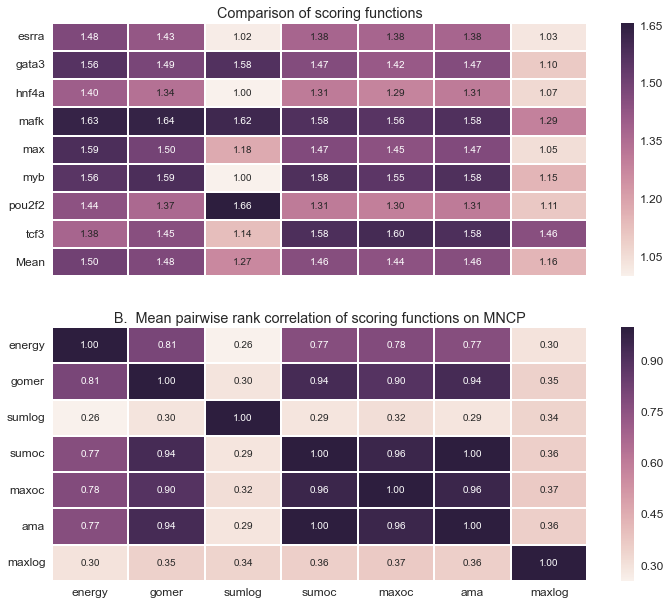

In [7]:
stat='mncp'
tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()


fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 10), sharex=True, sharey=False)
#fig, ax = plt.subplots()

sns.set(font_scale=1.2)

#fig.set_size_inches(10, 8)

scores = "energy	gomer	sumlog	sumoc	maxoc  ama	maxlog".split()

score_sum = pd.DataFrame(columns=scores)
for tf in tf_list:
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    mot_score =pd.read_table("%s/%s_%s.rawscores" % (results_path, tf, stat), index_col="Motif")
    #mot_score =pd.read_table("../Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    test = mot_score.mean().T
    con = test.to_frame(name=tf).T
    score_sum = score_sum.append(con)
score_sum = score_sum.append(score_sum.mean().to_frame(name="Mean").T)
sns.heatmap(score_sum, annot=True, ax=ax1, fmt='.2f')
ax1.set_title("Comparison of scoring functions")

tf = 'esrra'
stat = 'mncp'
results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
mot_score =pd.read_table("%s/%s_%s.rawscores" % (results_path, tf, stat), index_col="Motif")
#mot_score =pd.read_table("../Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
a = mot_score.corr(method='spearman')

#sns.clustermap(mot_score.corr(method='spearman'))

tf_list = "gata3 hnf4a mafk max myb pou2f2 tcf3".split()
for tf in tf_list:
    results_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    mot_score =pd.read_table("%s/%s_%s.rawscores" % (results_path, tf, stat), index_col="Motif")
    #mot_score =pd.read_table("../Results/%s/%s_%s.rawscores" % (tf,tf, stat), index_col="Motif")
    b = mot_score.corr(method='spearman')
    a = a.add(b)
sns.heatmap(a/8, annot=True, ax=ax2, fmt='.2f')
ax2.set_title("B.  Mean pairwise rank correlation of scoring functions on MNCP")
#f=plt.gcf()
#f.savefig('../Figures/Figure6_effect_of_scoring_auc.pdf', bbox_inches='tight')
f=plt.gcf()
f.savefig('../Figures/FigureS2_effect_of_scoring_mncp_new.pdf', bbox_inches='tight')

###Figure 8: Effect of motif length and information content on morif ranking: Figure S3

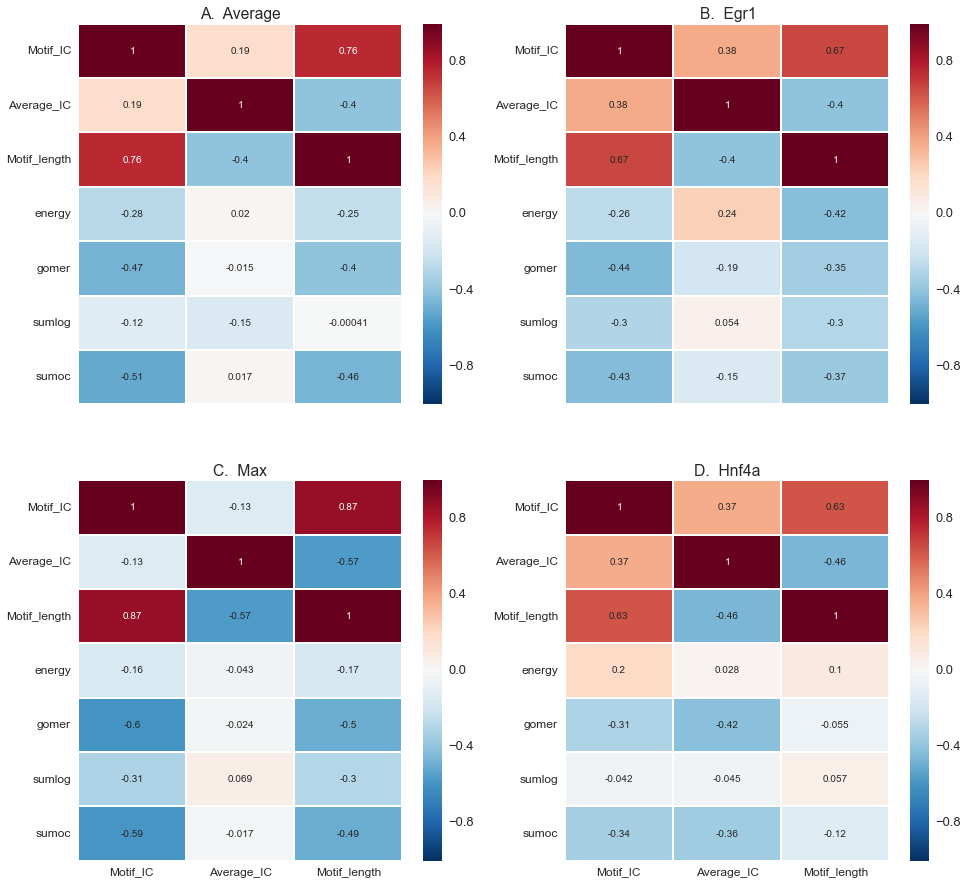

In [8]:
tf ='egr1' #initialize
stat = 'auc'
tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()

tf_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
#tf_path = "../Results/%s" % tf
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
score_ic = df.corr()

for tf in tf_list:
    tf_path = '%s/PBM/Results/%s' % (BASE_DIR, tf.capitalize())
    #df = tf+"_df"
    df1 = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf,stat), index_col="Motif_name")
    score_ic2 = df1.corr()
    score_ic = score_ic.add(score_ic2, fill_value=0)
test = score_ic/(len(tf_list)+1)

del test['energy']
del test['gomer']
del test['sumlog']
del test['sumoc']

test = test


#path = '../Results'
path = '%s/PBM/Results' % (BASE_DIR)
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 15), sharex=True, sharey=False)
sns.set(font_scale=1.3)
sns.heatmap(test, annot=True, ax=ax1)
ax1.set_title("A.  Average")

tf = "egr1"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax2)
ax2.set_title('B.  '+tf.capitalize())

tf = "max"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df

sns.heatmap(df, annot=True, ax = ax3)
ax3.set_title('C.  '+tf.capitalize())

tf = "hnf4a"
tf_path = "%s/%s" % (path, tf.capitalize())
df = pd.read_table("%s/%s_%s_score_ic.txt" % (tf_path, tf, stat), index_col="Motif_name")
df = df.corr()
del df['energy']
del df['gomer']
del df['sumlog']
del df['sumoc']

df = df
sns.heatmap(df, annot=True, ax = ax4)
ax4.set_title('D.  '+tf.capitalize())

f.savefig('../Figures/FigureS3_motif_length_ic_effect_minimal.pdf', bbox_inches='tight')

In this case scenarior, we observed stronger negative correlation between the occupancy scores and motif length -0.47 cmpared with -0.28 of energy scoring. This difference was not observed when using ChIP-seq data. Could this explain why the energy scores are much higher than the GOMER scores in PBM as shown in figure 6 and 7? It is highly likely. 

###Figure9..How motif databases rankes is affected by scoring functions and statistic used: Figure S4

In [9]:
#tf_list=["gata3", "hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1']
tf_list = "egr1 esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
selected_col =['JASPAR', 'HOCOMOCO',  'HOMER', 'POUR', 'JOLMA', 'GUERTIN', 'ZLAB',
               'TF2DNA', 'SWISSREGULON', 'CIS-BP', 'UNIPROBE','3DFOOTPRINT']
for score in ('energy','gomer', 'ama','sumlog', 'maxoc', 'sumoc'):
    for stat in ('mncp','auc'):
        stat_dict= {'auc':1, "mncp":2}
        
        #tf_list=["gata3", "hnf4a","pou2f2",'yy1','ctcf','cebpb', 'mef2a', 'esrra', 'prdm1', 'pax5', 'elf1', 'egr1']


        cent_out = []
        cols = 0
        i=1
        cent_out.append(["Motif"])
        for tf in tf_list:
            tf_path = '%s/PBM/Results' % BASE_DIR
            cent_out.append([tf])
            for col in selected_col:
                if cols ==0:
                    cent_out[0].append(col)
                with open("%s/%s/%s.%s" % (tf_path, tf.capitalize(), tf, score)) as cent:
                    flag =0
                    for line in cent:
                        if flag==0:
                            if col in line:
                                cent_out[i].append(line.split()[stat_dict[stat]])
                                flag = 1
                    if flag ==0:
                        cent_out[i].append("")
            i+=1
            cols = 1
        with open('%s/Db_ranks_%s_%s.txt' % (tf_path, score,stat), 'w') as raw_out:
            for row in cent_out:
                raw_out.writelines('\t'.join(map(str, row)) + '\n')
    

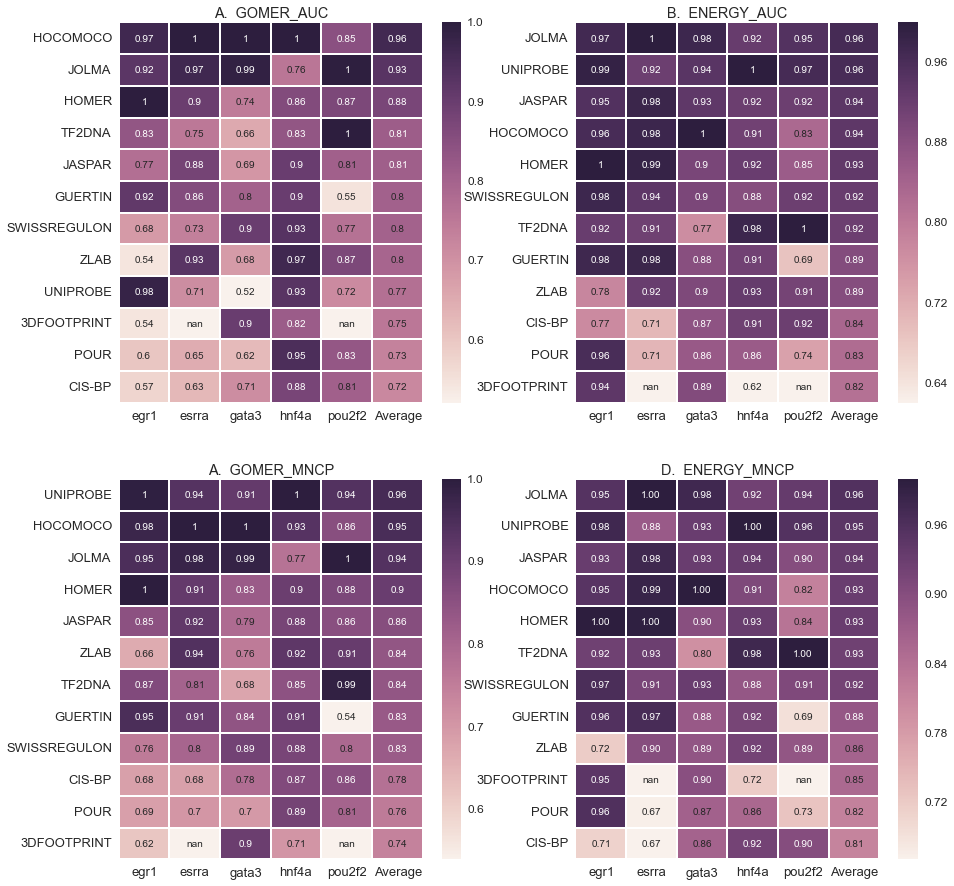

In [10]:
tf_path = '%s/PBM/Results' % BASE_DIR
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 15), sharex=False, sharey=False)
i=1
sns.set(font_scale=1.2)
stat = 'auc'
score = 'gomer'
axi="ax"+str(i)
cent_col = pd.read_table('%s/Db_ranks_%s_%s.txt' % (tf_path, score, stat), index_col="Motif")
tf_list = "esrra gata3 hnf4a pou2f2 ".split()
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
tf ='egr1'
a = cent_col.T[tf]/cent_col.T[tf].max()
d = a.to_frame().T

for tf in tf_list:
    a = cent_col.T[tf]/cent_col.T[tf].max()
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T

new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('A.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

stat = 'auc'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('%s/Db_ranks_%s_%s.txt' % (tf_path, score, stat), index_col="Motif")

#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
tf ='egr1'
a = cent_col.T[tf]/cent_col.T[tf].max()
d = a.to_frame().T

for tf in tf_list:
    a = cent_col.T[tf]/cent_col.T[tf].max()
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('B.  '+score.upper()+"_"+stat.upper())
i+=1
#f.savefig('MATOM/static/files/Db_ranks_%s_%s.png' % (score, stat), bbox_inches='tight')

sns.set(font_scale=1.2)
stat = 'mncp'
score = 'gomer'
axi="ax"+str(i)
cent_col = pd.read_table('%s/Db_ranks_%s_%s.txt' % (tf_path, score, stat), index_col="Motif")
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
tf ='egr1'
a = cent_col.T[tf]/cent_col.T[tf].max()
d = a.to_frame().T

for tf in tf_list:
    a = cent_col.T[tf]/cent_col.T[tf].max()
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi))
eval(axi).set_title('A.  '+score.upper()+"_"+stat.upper())
i+=1


stat = 'mncp'
score = 'energy'
axi="ax"+str(i)
cent_col = pd.read_table('%s/Db_ranks_%s_%s.txt' % (tf_path, score, stat), index_col="Motif")
#tf_list = "esrra gata3 hnf4a mafk max myb pou2f2 tcf3 ".split()
tf ='egr1'
a = cent_col.T[tf]/cent_col.T[tf].max()
d = a.to_frame().T

for tf in tf_list:
    a = cent_col.T[tf]/cent_col.T[tf].max()
    d = d.append(a.to_frame().T)

av = d.mean(axis=0)

con = av.to_frame(name='Average').T


new_mots = d.append(con).T


new_mots = new_mots.sort(columns="Average", axis=0, ascending=False).T
new_mots = new_mots.T
mask = new_mots.isnull()
sns.heatmap(new_mots, annot=True, ax = eval(axi), fmt='.2f')
eval(axi).set_title('D.  '+score.upper()+"_"+stat.upper())

f.savefig('../Figures/FigureS4_motif_database_ranks.pdf', bbox_inches='tight')

A few observations can definitely be made from the above figure, especially when we compare it with the one generated based on ChIP-seq data. 

1. Motifs generated using PBM technique perform best when using all the the three combinations, except when GOMER scoring and AUC are used. 
2. Energy scoring with either MNCP or AUC, or GOMER scoring with MNCP seem to have the same effect. This is the reason why I conclude that energy scoring and MNCP seem to have the same benefits: a preference for specific motifs. These may be long or have a higher IC. 
3. TF2DNA motifs seem to benefit most when GOMER scoring is used together with AUC statistic.The TF2DNA motifs are only 7bp in length, which could mean that GOMER-AUC favours shorter motifs. This is observed only in PBM data maybe because the binding sites are generated in 8-mers. However, ChIP-seq sequences do not seem to encounter the same problem. 
4. Here, we can see that the choice of scoring function does actually greatly affect the ranking of the Databases. 
5. That a lot of care needs to be taken when using the PBM data in the analysis. A lot more pitfalls and causes of bias available. 